# Spam vs. Ham Email (SMS Dataset)
- Difficulty: Intermediate
- Project Purpose: Classify spam vs ham using Logistic Regression on TF–IDF; stretch → compare L1 vs L2 penalties.
- Points Examined: LogisticRegression, penalties (l1, l2), solvers (liblinear, saga).
- Doc References: Logistic regression, Regularization.
- Why Useful: Intro to classification; highlights sparse vs dense coefficients.

# Part 0 Data Download

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
!curl -L -o ./190k-spam-ham-email-dataset-for-classification.zip https://www.kaggle.com/api/v1/datasets/download/meruvulikith/190k-spam-ham-email-dataset-for-classification

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  106M  100  106M    0     0  12.8M      0  0:00:08  0:00:07  0:00:01 17.2M 0  0:00:08  0:00:08 --:--:-- 19.1M


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
data = pd.read_csv('./190k-spam-ham-email-dataset-for-classification.zip')

In [3]:
data.shape

(193852, 2)

# Part 1 Hypothesis and plan of notebook

We want to use logistic regression to test whether a message is span or ham. And the architecture we want to use is:
1. use tfidf to encode each text
2. doing logistic regression on top of that

- I believe this method will work because there are distinct words in spam/ham that will be strong classifier, as their word space doesn't seems to overlap and we don't need to capture the semantic meaning between. We will verify that by doing a n gram = (2, 2) to see if there's significant performance difference.
- For classification, will draw the ConfusionMatrix to see if there are some miss classification, and if there are many, need to check and see why.
- For the purpose of this project, will also compare between different solvers: (liblinear, saga). Based on the reading, since I have 193852 data, I would assume sage's speed is faster than liblinear, as sage is doing gradient descent while liblinear is looking at one whole column at once, will verify that by comparing the time diff.

# Part 2 Pre-processing


In [4]:
data = data.dropna()
X = data.iloc[:, data.columns != 'label']
y = data['label']

<Axes: xlabel='label'>

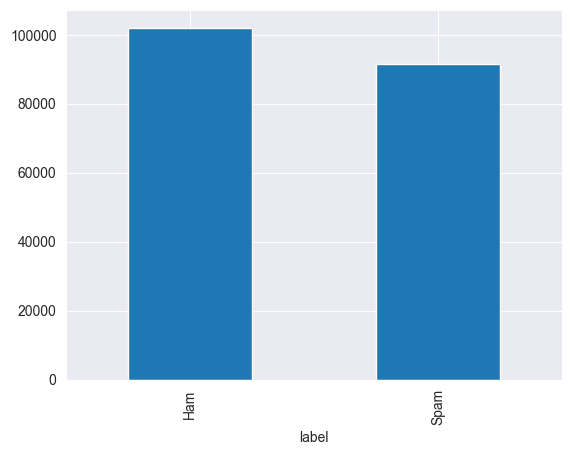

In [5]:
data.groupby('label').size().plot(kind='bar')
# We see that there is no specific imbalance between classes, so we will not do re-sampling nor missing value filling

In [6]:
# For now, will just use the default word breaker for tfidf tokenizer, but as a stretch, will try Lemmatization to see how things goes so at this stage, won't need any preprocessing, will just default for all.

# Since we have 190k data, will do a train test split and its unlikely we got any lucky split, so will just do train test split without learning curve this time.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test = list(X_train['text']), list(X_test['text'])

# Part 3 Training & Comparing (1,1)/ (2,2) n-gram, l1, l2 solver

In [56]:
# Part 3 Training & Comparing (1,1)/ (2,2) n-gram, l1, l2 solver
lgr_l1 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words='english'),
    LogisticRegression(penalty='l1', solver='liblinear')
)

lgr_l2 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words='english'),
    LogisticRegression(penalty='l2')
)

lgr_l1_2 = make_pipeline(
    TfidfVectorizer(ngram_range=(2, 2), stop_words='english'),
    LogisticRegression(penalty='l2')
)

lgr_l1.fit(X_train, y_train)
lgr_l2.fit(X_train, y_train)
lgr_l1_2.fit(X_train, y_train)
print(lgr_l1.score(X_test, y_test))
print(lgr_l2.score(X_test, y_test))
print(lgr_l1_2.score(X_test, y_test))

0.9758060355945318
0.9789270054165592
0.9755481042042816


In [8]:
# The result above are all suspiciously high. Rather than claim it is a lucky split, I tend to the following:
# 1. There are some strong indicator (will examine by print coef * mean in below)
# 2. There are some kind of data leakage, maybe some information get pre-processed into the data before download
# 3. We see that there is a 1% increase with 2-grand model, need to plot the top x feature to see if that make sense semantically or its just a lucky split.

# Part 4 Print the Confusion Matrix

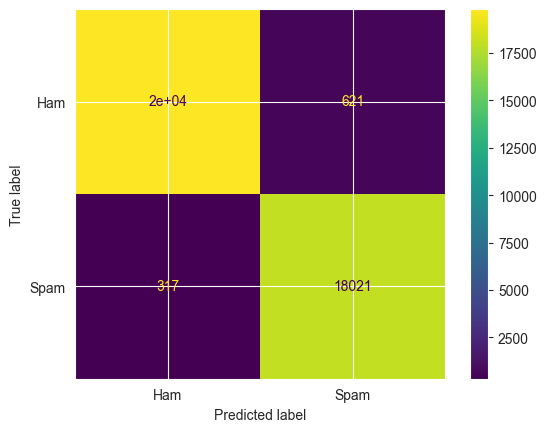

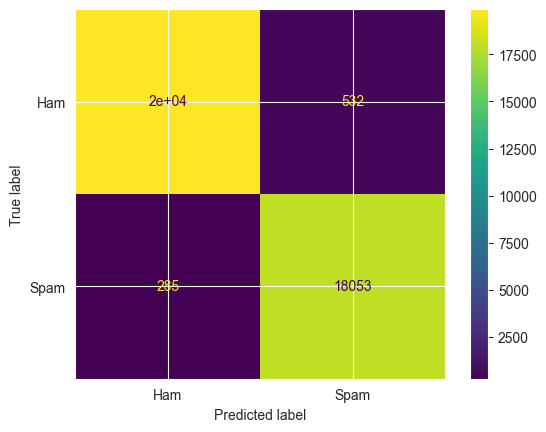

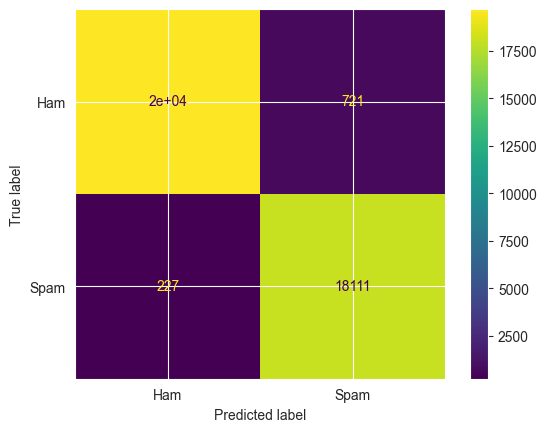

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model in [lgr_l1, lgr_l2, lgr_l1_2]:
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()
    # One interesting finding is that even the lgr_l1_2 have higher score, it actually has more error samples compared to lgr_l2, why :(

# Part 5 Explore key-words
Now we explore the top words for each of the model per ech of the class.

In [49]:
def get_top_feature_names(pipeline_model, X_train, top_k=20):
    coefs = pipeline_model[1].coef_[0]
    feature_means = np.asarray(pipeline_model[0].transform(X_train).mean(axis=0)).ravel()
    feature_importance = coefs * feature_means
    feature_names = pipeline_model[0].get_feature_names_out()
    df = pd.DataFrame({"word_weight": feature_importance, "words": feature_names})
    df.sort_values("word_weight", ascending=True, inplace=True)
    print(f"Top {top_k} strongest word for {pipeline_model[1].classes_[0]}:", df.iloc[:top_k, :])
    print(f"Top {top_k} strongest word for {pipeline_model[1].classes_[1]}:", df.iloc[-top_k:, :])

get_top_feature_names(lgr_l1, X_train)
get_top_feature_names(lgr_l2, X_train)
get_top_feature_names(lgr_l1_2, X_train)

Top 20 strongest word for Ham:         word_weight         words
121923    -0.397193  escapenumber
118937    -0.342748         enron
340552    -0.219207        thanks
330310    -0.211872       subject
130089    -0.122994          ethz
42167     -0.115542      attached
306182    -0.111137         samba
211637    -0.095002      listinfo
266299    -0.094814          perl
379558    -0.085954         wrote
380430    -0.074888           www
312251    -0.068718          sent
256688    -0.061828           org
286504    -0.061799     questions
200078    -0.059072          know
149029    -0.058967           gas
214722    -0.056532        louise
224858    -0.054874       meeting
365934    -0.054157         vince
251318    -0.048907       october
Top 20 strongest word for Spam:         word_weight          words
252088     0.027337          offer
179919     0.027711           info
76447      0.028569          click
168052     0.029860             hk
52316      0.030108           best
224728     0.

In [11]:
# we see that escapenumber, escapelong is mentioned too many times in many of the key word, which is a bit noise and we want to exclude it during preprocessing.
# Also, notice that http is used as top 1 feature for spam, this maybe comes from the spam link, but could also due to data leakage that some metadata tagging info is pushed inside the data

In [57]:
# Now lets remote escape* from the original doc and re-run the three model.
import re
def pre_remove_words_with_escape(text: str) -> str:
    if text is None:
        return ""
    s = str(text).lower()                      # mimic default lowercasing
    s = re.sub(r'\b\S*escape\S*\b', '', s)     # drop words like escape, escaped, escapee
    s = re.sub(r'\s{2,}', ' ', s).strip()      # tidy spaces
    return s

lgr_l1 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words='english', preprocessor=pre_remove_words_with_escape),
    LogisticRegression(penalty='l1', solver='liblinear')
)

lgr_l2 = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 1), stop_words='english', preprocessor=pre_remove_words_with_escape),
    LogisticRegression(penalty='l2')
)

lgr_l1_2 = make_pipeline(
    TfidfVectorizer(ngram_range=(2, 2), stop_words='english', preprocessor=pre_remove_words_with_escape),
    LogisticRegression(penalty='l2')
)

lgr_l1.fit(X_train, y_train)
lgr_l2.fit(X_train, y_train)
lgr_l1_2.fit(X_train, y_train)
print(lgr_l1.score(X_test, y_test))
print(lgr_l2.score(X_test, y_test))
print(lgr_l1_2.score(X_test, y_test))

0.9757802424555069
0.9778436935775083
0.9806293525922105


In [51]:
# Now we print top words again
get_top_feature_names(lgr_l1, X_train)
get_top_feature_names(lgr_l2, X_train)
get_top_feature_names(lgr_l1_2, X_train)

Top 20 strongest word for Ham:         word_weight      words
114280    -0.331380      enron
321054    -0.225766     thanks
311231    -0.224938    subject
287758    -0.137758      samba
40560     -0.118287   attached
118568    -0.112067       ethz
196723    -0.102122   listinfo
249379    -0.097642       perl
358537    -0.094560      wrote
359349    -0.080229        www
293701    -0.072346       sent
240017    -0.067621        org
268717    -0.064389  questions
136792    -0.064061        gas
254643    -0.063632         pm
185682    -0.059652       know
199707    -0.058632     louise
209554    -0.057254    meeting
234906    -0.055089    october
124244    -0.054580        fax
Top 20 strongest word for Spam:         word_weight       words
276455     0.024874      remove
252439     0.025994       pills
235575     0.026421       offer
73581      0.028416       click
166490     0.028596        info
277141     0.029517       reply
71699      0.030233      cialis
50316      0.030878        bes

In [52]:
# Now the top words make much more sense

# Part 6 Compare the solving speed for different solvers

In [53]:
# Noticed that both tfidf and training/inference cost a lot of time. So here we will compare the speed of default solver and saga solver
tfidf_train, tfidf_test = lgr_l1[0].transform(X_train), lgr_l1[0].transform(X_test)

In [54]:
lgr_liblinear = LogisticRegression(penalty='l2', solver='liblinear')
lgr_lbfgs = LogisticRegression(penalty='l2', solver='lbfgs')
lgr_sage = LogisticRegression(penalty='l2', solver='saga')

In [55]:
from time import time
t = time()
lgr_liblinear.fit(tfidf_train, y_train)
print(f"lgr_liblinear took {time() - t} seconds to fit, with testing score of {lgr_liblinear.score(tfidf_train, y_train)}")
t = time()
lgr_lbfgs.fit(tfidf_train, y_train)
print(f"lgr_lbfgs took {time() - t} seconds to fit, with testing score of {lgr_lbfgs.score(tfidf_train, y_train)}")
t = time()
lgr_sage.fit(tfidf_train, y_train)
print(f"lgr_sage took {time() - t} seconds to fit, with testing score of {lgr_sage.score(tfidf_train, y_train)}")

lgr_liblinear took 3.513763904571533 seconds to fit, with testing score of 0.9871937064740779
lgr_lbfgs took 1.719301700592041 seconds to fit, with testing score of 0.9845950477173072
lgr_sage took 3.5417981147766113 seconds to fit, with testing score of 0.9871937064740779


In [ ]:
# lbfgs is much faster than the other two. Need reason why.

# Part 7 GPT review

Fixes & improvements (no code needed)

Evaluate on the test set where you compare models

In Part 3 you print model.score(X_train, y_train). That’s training accuracy and can mislead (especially with bigrams). When comparing models, report test accuracy/F1 (or cross-val) consistently.

Name clarity

lgr_l1_2 actually uses L2 with bigrams. Rename (e.g., lgr_l2_bi) to avoid confusion later.

Vectorizer settings to try (usually help on text)

sublinear_tf=True (log-scaled TF often stabilizes linear models).

min_df: start with 2–5 (especially for bigrams) to drop ultra-rare features and reduce overfitting + memory.

Consider keeping stopwords initially (stop_words=None). In spam classification, words like not, no, you may carry signal; TF-IDF already downweights common words. Compare both ways.

If memory is tight: dtype=np.float32.

Bigrams overfitting

If (2,2) improved train score but worsened test errors, that’s classic overfitting to rare bigrams. Raise min_df for the bigram model and/or use L1/ElasticNet (with saga) to prune.

Timing comparison hygiene

You did the right thing by transforming TF-IDF once and reusing it. Also:

For saga, set a higher max_iter (e.g., 1000–2000) and possibly a slightly looser tol so it converges. Default max_iter=100 can underfit/drag out convergence comparisons.

For liblinear, dual=True helps when features ≫ samples (L2 only). On text, it can sometimes be faster.

Top words inspection

Your coef × mean(feature) view is great for “average push.” Also look at raw coef ranking (strongest when present). For L1 models, check sparsity (how many features zeroed).

Preprocessor

Your pre_remove_words_with_escape is correct and mirrors the vectorizer’s lowercase path. Good.

Keep in mind: with a custom preprocessor, scikit-learn doesn’t apply its own lowercasing—so you did the right thing by lowercasing inside the function.

“http” as a top feature

That’s not leakage by itself—links are genuinely predictive for spam. It would be leakage only if labels or metadata were injected into text. (You later use only ['text'], so you’re good.)

Reproducibility

Set random_state for train_test_split (you did) and for LogisticRegression(solver='saga', random_state=42) to lock runs.

Reporting

Add precision, recall, F1, ROC-AUC on test for each variant (accuracy alone can hide shifts in FP/FN tradeoffs).

Consider a PR curve (often more informative for spam)




Answers to your in-notebook questions

Q (Part 3/16):

“Even though the bigram model had a higher score, its confusion matrix shows more errors—why?”

You printed training scores earlier; the confusion matrices are on the test set. Bigrams often raise train accuracy but hurt test via overfitting (especially with min_df=1). Use test F1/accuracy for comparison, and/or increase min_df and try L1/ElasticNet on the bigram model.

Q (Part 6/27):

“lbfgs is much faster than the other two. Need reason why.”

With L2 on a moderately large but not gigantic dataset, lbfgs’s batch, curvature-aware steps often converge in few iterations, each a full pass but efficient in C.

liblinear (coordinate descent) can be slower in very high dimensions for binary problems; it iterates feature-wise and may need more passes.

saga has cheap iterations, but needs more of them; with default max_iter=100, it often hasn’t fully converged, and with higher max_iter it can take longer wall-clock. Properly tuned saga shines on very large, sparse problems and is needed for L1/ElasticNet and multinomial.

TL;DR: For your setup (L2, binary TF-IDF, one full transform), lbfgs is a sweet spot.